benign = 393 and malignant = 10000

train = 1:8000 , 0:1896

val = 1:2000 , 0:472

train with alexnet

result

Epoch 01 - Train: 0.3904, 87.37% | Val: 0.4887, 80.91%

Epoch 02 - Train: 0.5113, 88.73% | Val: 0.3354, 96.16%

Epoch 03 - Train: 0.2267, 95.60% | Val: 0.1268, 96.89%

Epoch 04 - Train: 0.1718, 96.29% | Val: 0.1396, 96.72%

Epoch 05 - Train: 0.1501, 96.44% | Val: 0.1254, 96.76%

Epoch 06 - Train: 0.1876, 95.85% | Val: 0.1513, 96.89%

Epoch 07 - Train: 0.1702, 96.09% | Val: 4.9579, 93.08%

Epoch 08 - Train: 0.2465, 95.75% | Val: 0.1479, 96.36%

Epoch 09 - Train: 0.1784, 95.91% | Val: 0.1395, 96.68%

Epoch 10 - Train: 0.1824, 96.08% | Val: 0.1397, 96.68%

clip_limit=4.0, tile_size=(16, 16)

In [1]:
import os
import pandas as pd
import shutil

# === 1. Load metadata CSV and prepare paths ===
meta_dir = '/kaggle/input/isic-2024-challenge/'
image_dir = os.path.join(meta_dir, 'train-image/image')
csv_path = os.path.join(meta_dir, 'train-metadata.csv')

# Read the metadata
df = pd.read_csv(csv_path)

# Add image filename column
df['filename'] = df['isic_id'].astype(str) + '.jpg'

print("Total images in dataset:", len(df))

/tmp/ipykernel_35/91138490.py:11: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Total images in dataset: 401059


In [2]:
import cv2
import numpy as np

def apply_clahe(image, clip_limit=4.0, tile_size=(8, 8)):
    """Apply CLAHE to a BGR image"""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

In [3]:
# filter malignant (target == 1)
df_positive = df[df["target"] == 1]

# filter benign (target == 0), randomly sample 10,000 rows
df_negative = df[df["target"] == 0].sample(n=10000, random_state=42)

# combine both positive and negative cases
df_balanced = pd.concat([df_positive, df_negative]).reset_index(drop=True)

# shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# save to a new CSV
csv_output_path = "/kaggle/working/train_created.csv"
df_balanced.to_csv(csv_output_path, index=False)

print("Balanced CSV saved to:", csv_output_path)
print("Total balanced samples:", len(df_balanced))
print("Malignant:", (df_balanced['target'] == 1).sum(), "| Benign:", (df_balanced['target'] == 0).sum())

Balanced CSV saved to: /kaggle/working/train_created.csv
Total balanced samples: 10393
Malignant: 393 | Benign: 10000


In [4]:
output_dir = '/kaggle/working/sampled_dataset'
malignant_out = os.path.join(output_dir, 'malignant')
benign_out = os.path.join(output_dir, 'benign')
os.makedirs(malignant_out, exist_ok=True)
os.makedirs(benign_out, exist_ok=True)

# Copy images by class
def copy_images_with_clahe(df_subset, label_value, dest_folder, clip_limit=2.0):
    df_filtered = df_subset[df_subset["target"] == label_value]
    for _, row in df_filtered.iterrows():
        src_path = os.path.join(image_dir, row['filename'])
        dst_path = os.path.join(dest_folder, row['filename'])
        if os.path.exists(src_path):
            image = cv2.imread(src_path)
            enhanced = apply_clahe(image, clip_limit=clip_limit)
            cv2.imwrite(dst_path, enhanced)

# Copy malignant (target == 1) and benign (target == 0)
copy_images_with_clahe(df_balanced, 1, malignant_out)
copy_images_with_clahe(df_balanced, 0, benign_out)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import time
import pickle

In [6]:
from torchvision.transforms import functional as TF
import random

def augment_malignant_image(img):
    augmented = []

    for _ in range(5):  # 5 augmentations per image
        transformed = img.copy()

        if random.random() > 0.5:
            transformed = TF.hflip(transformed)
        if random.random() > 0.5:
            transformed = TF.vflip(transformed)
        angle = random.uniform(-10, 10)
        transformed = TF.rotate(transformed, angle)
        scale = random.uniform(0.9, 1.1)
        width, height = transformed.size
        new_w, new_h = int(width * scale), int(height * scale)
        transformed = transformed.resize((new_w, new_h))
        transformed = TF.center_crop(transformed, (224, 224))
        augmented.append(transformed)
    
    return augmented

In [7]:
# === Paths ===
malignant_out = '/kaggle/working/sampled_dataset/malignant'
benign_out = '/kaggle/working/sampled_dataset/benign'
aug_malignant_dir = '/kaggle/working/aug_malignant'
os.makedirs(aug_malignant_dir, exist_ok=True)

# === Prepare Dataset (Malignant + Augmented + Benign) ===
image_paths, labels = [], []
augmented_paths, augmented_labels = [], []

for img_file in os.listdir(malignant_out):
    if img_file.endswith('.jpg'):
        path = os.path.join(malignant_out, img_file)
        image_paths.append(path)
        labels.append(1)

        # Augment
        img = Image.open(path).convert('RGB')
        augmented = augment_malignant_image(img)
        for i, aug_img in enumerate(augmented):
            aug_name = f"{img_file.split('.')[0]}_aug{i}.jpg"
            aug_path = os.path.join(aug_malignant_dir, aug_name)
            aug_img.save(aug_path)
            augmented_paths.append(aug_path)
            augmented_labels.append(1)

# Add augmented malignant
image_paths += augmented_paths
labels += augmented_labels

# Sample exactly 10,000 benign images (randomly)
benign_files = [f for f in os.listdir(benign_out) if f.endswith('.jpg')]
random.seed(42)
sampled_benign = random.sample(benign_files, 10000)

for img_file in sampled_benign:
    image_paths.append(os.path.join(benign_out, img_file))
    labels.append(0)


# === Split ===
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# === Transforms ===
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
from collections import Counter

print("Training set class distribution:")
print(Counter(train_labels))  # Output: {0: ..., 1: ...}

print("\nValidation set class distribution:")
print(Counter(val_labels))    # Output: {0: ..., 1: ...}

Training set class distribution:
Counter({0: 8000, 1: 1886})

Validation set class distribution:
Counter({0: 2000, 1: 472})


In [9]:
class ISICDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img), self.labels[idx]

train_loader = DataLoader(ISICDataset(train_paths, train_labels, train_transform), batch_size=16, shuffle=True)
val_loader = DataLoader(ISICDataset(val_paths, val_labels, val_transform), batch_size=16, shuffle=False)

In [10]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 11, 4, 2), nn.ReLU(inplace=True), nn.MaxPool2d(3, 2),
            nn.Conv2d(64, 192, 5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(3, 2),
            nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(3, 2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(256 * 6 * 6, 4096), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

import torch
print(torch.cuda.is_available())
print("Using device:", device)

True
Using device: cuda


In [12]:
def run_epoch(loader, train):
    model.train() if train else model.eval()
    total, correct, loss_sum = 0, 0, 0
    with torch.set_grad_enabled(train):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loss_sum += loss.item()
    return loss_sum / len(loader), 100. * correct / total

In [13]:
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

start = time.time()

for epoch in range(epochs):
    train_loss, train_acc = run_epoch(train_loader, True)
    val_loss, val_acc = run_epoch(val_loader, False)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1:02d} - Train: {train_loss:.4f}, {train_acc:.2f}% | Val: {val_loss:.4f}, {val_acc:.2f}%")

# === Save Results ===
torch.save(model.state_dict(), '/kaggle/working/alexnet_model.pth')
with open('/kaggle/working/alexnet_results.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'epochs': epochs,
        'best_val_acc': max(val_accs),
        'training_time': time.time() - start
    }, f)

Epoch 01 - Train: 0.3904, 87.37% | Val: 0.4887, 80.91%
Epoch 02 - Train: 0.5113, 88.73% | Val: 0.3354, 96.16%
Epoch 03 - Train: 0.2267, 95.60% | Val: 0.1268, 96.89%
Epoch 04 - Train: 0.1718, 96.29% | Val: 0.1396, 96.72%
Epoch 05 - Train: 0.1501, 96.44% | Val: 0.1254, 96.76%
Epoch 06 - Train: 0.1876, 95.85% | Val: 0.1513, 96.89%
Epoch 07 - Train: 0.1702, 96.09% | Val: 4.9579, 93.08%
Epoch 08 - Train: 0.2465, 95.75% | Val: 0.1479, 96.36%
Epoch 09 - Train: 0.1784, 95.91% | Val: 0.1395, 96.68%
Epoch 10 - Train: 0.1824, 96.08% | Val: 0.1397, 96.68%


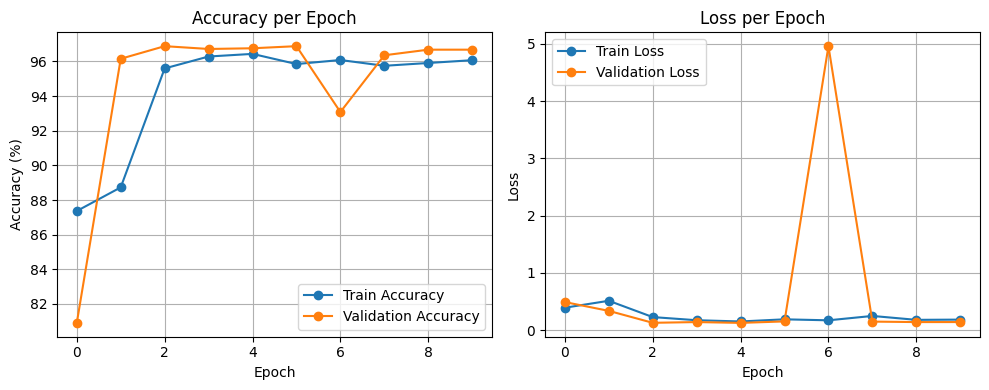

In [14]:
import matplotlib.pyplot as plt

# === Plot Accuracy ===
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# === Plot Loss ===
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/alexnet_training_curves.png')
plt.show()